# Welcome to the 2020 Low Flow Data Processing Script.
***
### This is the county data
#### click in cell and then alt+Enter to execute
#### Follow through the steps below to produce wonderfully accurate and high quality flow data
#### Enjoy!

## Define site name and start/end times
***

In [817]:
## Update the Site Name and start/end times
site_name = 'SWT-030'

import datetime as dt
start_time_loc = dt.datetime(2021,5,1,0,0)
end_time_loc = dt.datetime(2021,7,4,0,0)

data_deliverable_end_time_loc =  dt.datetime(2021,6,30,23,55)

In [818]:
#!jt -t onedork

In [819]:
## Data Directories (will hopefully replace with a database soon)
maindir = 'C:/Users/alex.messina/Documents/GitHub/2021_County_LowFlow/'
import os
os.chdir('C:/Users/alex.messina/Documents/GitHub/2021_County_LowFlow/Python_code/')

In [820]:
%matplotlib notebook
## Import Standard modules
import pandas as pd
import datetime as dt
import string
import textwrap
import numpy as np
import calendar
from scipy import signal
## Plotting modules
import matplotlib as mpl
from matplotlib import pyplot as plt
## Jupyter interactive plots
import mpld3
mpld3.enable_notebook()
## for Zentra API
from pytz import timezone
import json
#import urllib2
## for OneRain data getter 
import requests
import time
#from BeautifulSoup import BeautifulSoup
## Get google sheets
#import gspread
#from oauth2client.service_account import ServiceAccountCredentials
#from df2gspread import df2gspread as d2g 
## Image tools
import matplotlib.image as mpimg
from scipy import ndimage
#from PIL import Image
## Path to Custom modules
import sys
sys.path.append('..')
# Import Custom Modules
#from ZentraAPI import *
#from Get_GoogleSheets import *
#from OneRain_data import *
from Excel_Plots_2021 import *
from OvertoppingFlows import *
#from hover_points import *
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>    div#notebook-container    { width: 95%; }    div#menubar-container    
{ width: 80%; }    div#maintoolbar-container { width: 99%; } </style> """))       
## Display outputs side by side
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))
## Open HvF table - can be Google Sheets or straight from GitHub?
#HvF = pd.read_csv(maindir+'Ancillary_files/HvF-90degweir.csv',index_col='Level (in)') # Local file
#Hvf = open_HvF_90degweir()  # Google Sheets
HvF = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/HvF-90degweir.csv',index_col=0) # GitHub
## WEIR DIMENSIONS FOR OVERTOPPING FLOWS - can be Google Sheets or straight from GitHub?
weir_dims = pd.read_csv(maindir+'Ancillary_files/Weir_Dims_2021.csv',index_col='Site',na_values=['Not Applicable']) # Local file
#weir_dims = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/Weir_Dims_2020.csv',index_col=0,na_values=['Not Applicable']) # GitHub

## Site List
site_list = pd.read_excel(maindir+'PowerBI/Site_List.xlsx',sheet_name='Site_List',index_col=0)

print ("All modules imported. Let's go!")

All modules imported. Let's go!


## Water Level Data
***
#### from Local file or GitHub
#### original data is batch downloaded from Zentra via the ZentraAPI

In [821]:
## FROM CSV
## If data is already downloaded, load from csv
WL_all = pd.read_csv(maindir+'PowerBI/County2021/Flow_data_from_API_v3/Level_data_1.csv',index_col=0,parse_dates=True) # Local file
#WL = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2021_County_LowFlow/master/PowerBI/County2021/Flow_data_from_API_v3/Level_data_1.csv',index_col=0,parse_dates=True) # GitHub
WL = WL_all.loc[dt.datetime(2021,5,1,0,0):,[site_name + '_level_in']]
WL.columns  = ['in Water Level']
print (WL)

                     in Water Level
2021-05-05 00:00:00            4.41
2021-05-05 00:05:00            4.45
2021-05-05 00:10:00            4.41
2021-05-05 00:15:00            4.41
2021-05-05 00:20:00            4.41
2021-05-05 00:25:00            4.41
2021-05-05 00:30:00            4.41
2021-05-05 00:35:00            4.37
2021-05-05 00:40:00            4.41
2021-05-05 00:45:00            4.41
2021-05-05 00:50:00            4.41
2021-05-05 00:55:00            4.41
2021-05-05 01:00:00            4.41
2021-05-05 01:05:00            4.41
2021-05-05 01:10:00            4.45
2021-05-05 01:15:00            4.41
2021-05-05 01:20:00            4.41
2021-05-05 01:25:00            4.41
2021-05-05 01:30:00            4.41
2021-05-05 01:35:00            4.37
2021-05-05 01:40:00            4.41
2021-05-05 01:45:00            4.41
2021-05-05 01:50:00            4.41
2021-05-05 01:55:00            4.41
2021-05-05 02:00:00            4.41
2021-05-05 02:05:00            4.37
2021-05-05 02:10:00         

## Daily Rain data for deliverable
## Hourly Rain data for analysis
***

In [822]:
## Get the rain gauge used for the site
#rain_gauge_site_list = pd.DataFrame.from_csv(maindir+'Ancillary_files/Rain_gauge_to_sites_list.csv') # Local File
#rain_gauge_site_list = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2021_County_LowFlow/master/Ancillary_files/Rain_gauge_to_sites_list.csv',index_col=0) # GitHub
rain_gauge_name = site_list.loc['MS4-'+site_name,'rain_gauge_name']
print ('Rain gauge used for '+site_name+' is '+ rain_gauge_name)
## Rain gauges indexed by rain gauge name
#Rain_gauge_info = pd.DataFrame.from_csv(maindir+'Ancillary_files/Rain_gauge_info.csv') # Local File
#Rain_gauge_info = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/Rain_gauge_info.csv',index_col=0) # GitHub
start_date, end_date = start_time_loc.strftime('%Y-%m-%d'), end_time_loc.strftime('%Y-%m-%d')
Rain1D = pd.read_csv(maindir+'Rain_data/'+rain_gauge_name+'_daily.csv',index_col=0, parse_dates=True) # Local file
Rain1H = pd.read_csv(maindir+'Rain_data/'+rain_gauge_name+'_hourly.csv',index_col=0, parse_dates=True) # Local file
#Rain1D = pd.DataFrame.from_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Rain_data/'+rain_gauge_name.replace(' ','%20')+'_daily.csv') # GitHub
#Rain1H = pd.DataFrame.from_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Rain_data/'+rain_gauge_name.replace(' ','%20')+'_hourly.csv') # GitHub


## Check output 
Rain1D


Rain gauge used for SWT-030 is Roads Div I


,Rain_in
2021-05-01,0.00
2021-05-02,0.00
2021-05-03,0.00
2021-05-04,0.00
2021-05-05,0.00
2021-05-06,0.00
2021-05-07,0.00
2021-05-08,0.00
2021-05-09,0.00
2021-05-10,0.00


# Offsetting/Calibrating Water Level Data
***
1. Apply special offsets and clip bad data (storms will be clipped later)
2. Calculate and apply offset from calibration points 
3. global offset to manually adjust
#### >>> FINAL OFFSET saved to Google Sheets
####  
### 1a. Special Offsets
***

Special offsets: 
Special offset: 05/01/21 00:00 - 09/16/21 00:00 = 0.0 inches



C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


<IPython.core.display.Javascript object>


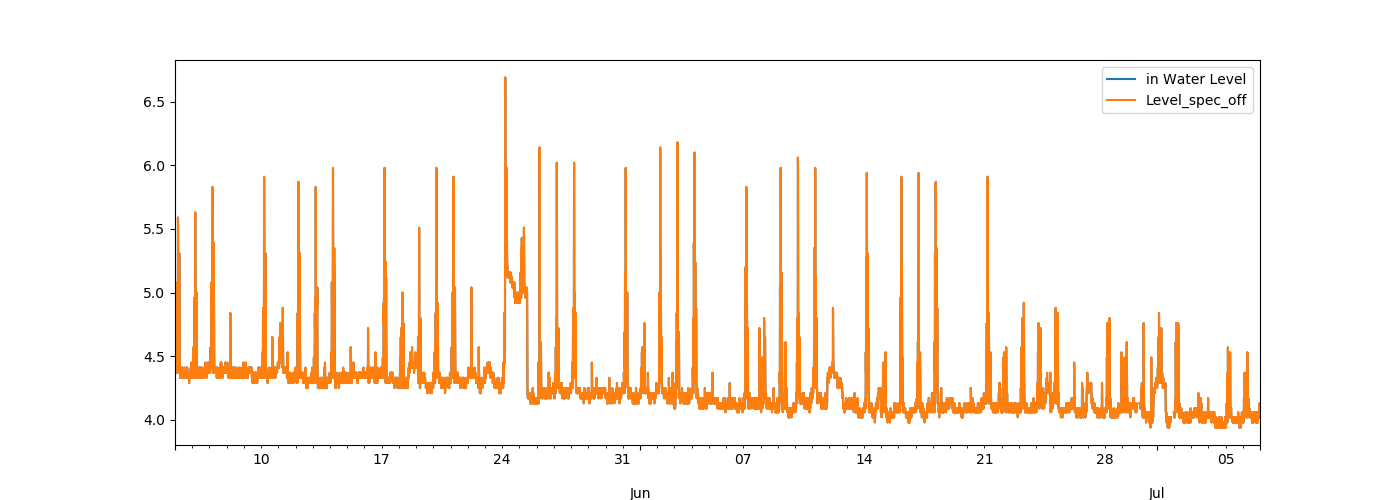

In [823]:
## Add column of zero for data offset
WL['spec_offset'] = 0.
## Special Offsets and Bad Data Clips, Global Offset from Google Sheets
spec_offsets  = pd.read_excel(maindir+'PowerBI/Site_List.xlsx',sheetname='SpecialOffsets',index_col=0)
## Get offsets for each site
offsets_list_for_site = spec_offsets[spec_offsets.index  == 'MS4-'+ site_name]
offsets_list_for_site
## THIS IS AS TUPLES SO THE TUPLE IS INDEXED BY NUMBER NOT STRING
for spec_offset in offsets_list_for_site.itertuples():
    print ('Special offsets: ')
    
    #print offset
    ## set data in bad_data indices to nan
    if pd.notnull(spec_offset.Start)==True and pd.notnull(spec_offset.End)==True:
        print ('Special offset: '+spec_offset.Start.strftime('%m/%d/%y %H:%M')+' - '+spec_offset.End.strftime('%m/%d/%y %H:%M')+' = '+str(spec_offset.SpecialOffset_in)+ ' inches')
        ## insert each offset value to Offset column
        mask = (WL.index > spec_offset.Start) & (WL.index <= spec_offset.End)
        WL.loc[mask, ['spec_offset']] = spec_offset.SpecialOffset_in
    else:
        pass
    print ('')   
## Apply all offsets for unique shifts due to bad data or other issues
WL['Level_spec_off'] = WL['in Water Level'] + WL['spec_offset']
WL['Level_spec_off'] = WL['Level_spec_off'].round(2)
WL[['in Water Level','spec_offset','Level_spec_off']].head()
WL[['in Water Level','Level_spec_off']].plot(figsize=(14,5))

### 1b. Clip bad data (don't want it used with Field Measurements)

In [824]:
clips =  pd.read_excel(maindir+'PowerBI/Site_List.xlsx',sheet_name='ClipBadData',index_col=0)

try: # one entry dataframes are weird
    clips_for_site = pd.DataFrame(clips.loc['MS4-'+site_name,:]).sort_values(by='Start')
    bad_data_clips = clips_for_site[clips_for_site['Reason'].isin(['Invalid','Obstruction'])]
except:
    try:
        clips_for_site = pd.DataFrame(clips.loc['MS4-'+site_name,:]).T # have to make DF and Transpose it 
        bad_data_clips = clips_for_site[clips_for_site['Reason'].isin(['Invalid','Obstruction'])]
    except KeyError:
        print ('No clips found')
        bad_data_clips = pd.DataFrame()
    
## iterate over list of bad data and clip from 'offset_flow_clipped'....
print ('Clipping bad/invalid data....')
WL['Level_spec_off_clipbad'] = WL['Level_spec_off']
for clip in bad_data_clips.iterrows():
    clip_start, clip_end = clip[1]['Start'], clip[1]['End']
    if pd.isnull(clip_start)==False and pd.isnull(clip_end) == False:
        print ('Clipped Invalid data from: '+clip_start.strftime('%m/%d/%y %H:%M')+'-'+clip_end.strftime('%m/%d/%y %H:%M'))
        ## set data in WL indices to nan
        WL.loc[clip_start:clip_end, ['Level_spec_off_clipbad']] = np.nan
    else:
        print ('No data to clip...')
        pass   
#WL[['in Water Level','Level_spec_off','Level_spec_off_clipbad']].plot(figsize=(16,4))
bad_data_clips

Clipping bad/invalid data....
Clipped Invalid data from: 05/10/21 04:00-05/12/21 10:00
Clipped Invalid data from: 05/14/21 05:00-05/17/21 05:00
Clipped Invalid data from: 05/18/21 12:00-05/19/21 03:00
Clipped Invalid data from: 05/24/21 03:30-05/25/21 11:00
Clipped Invalid data from: 06/14/21 16:00-06/15/21 12:05
Clipped Invalid data from: 06/15/21 18:00-06/16/21 03:00
Clipped Invalid data from: 06/17/21 12:30-06/17/21 00:00
Clipped Invalid data from: 06/24/21 10:00-06/24/21 22:00
Clipped Invalid data from: 06/26/21 21:00-06/27/21 06:00
Clipped Invalid data from: 06/29/21 01:00-07/01/21 04:00


,Start,End,Reason,Notes,Analyst
Site,,,,,
MS4-SWT-030,2021-05-10 04:00:00,2021-05-12 10:00:00,Obstruction,NaN,AM
MS4-SWT-030,2021-05-14 05:00:00,2021-05-17 05:00:00,Obstruction,NaN,AM
MS4-SWT-030,2021-05-18 12:00:00,2021-05-19 03:00:00,Obstruction,NaN,AM
MS4-SWT-030,2021-05-24 03:30:00,2021-05-25 11:00:00,Obstruction,NaN,AM
MS4-SWT-030,2021-06-14 16:00:00,2021-06-15 12:05:00,Obstruction,NaN,NaN
MS4-SWT-030,2021-06-15 18:00:00,2021-06-16 03:00:00,Obstruction,NaN,NaN
MS4-SWT-030,2021-06-17 12:30:00,2021-06-17 00:00:00,Obstruction,NaN,NaN
MS4-SWT-030,2021-06-24 10:00:00,2021-06-24 22:00:00,Obstruction,NaN,NaN
MS4-SWT-030,2021-06-26 21:00:00,2021-06-27 06:00:00,Obstruction,NaN,NaN


# 2. Apply Calculated Offset
## from Power BI


In [825]:
## Calculate total offset  
calculated_offset = site_list.loc['MS4-'+site_name,'Offset_in']
print ('Calculated offset from Power BI, Excel sheet = '+str(calculated_offset)+' in')
## Copy over data that has already had special offsets applied and bad data clipped
## Apply calculated offset
WL['Level_spec_off_clipbad_calc_off'] = WL['Level_spec_off_clipbad'] + calculated_offset
WL.dropna().head()

Calculated offset from Power BI, Excel sheet = -3.54 in


,in Water Level,spec_offset,Level_spec_off,Level_spec_off_clipbad,Level_spec_off_clipbad_calc_off
2021-05-05 00:00:00,4.41,0.0,4.41,4.41,0.87
2021-05-05 00:05:00,4.45,0.0,4.45,4.45,0.91
2021-05-05 00:10:00,4.41,0.0,4.41,4.41,0.87
2021-05-05 00:15:00,4.41,0.0,4.41,4.41,0.87
2021-05-05 00:20:00,4.41,0.0,4.41,4.41,0.87


### 3. Apply Global Offset
***

Global offset for SWT-030 = 0 in.


<IPython.core.display.Javascript object>


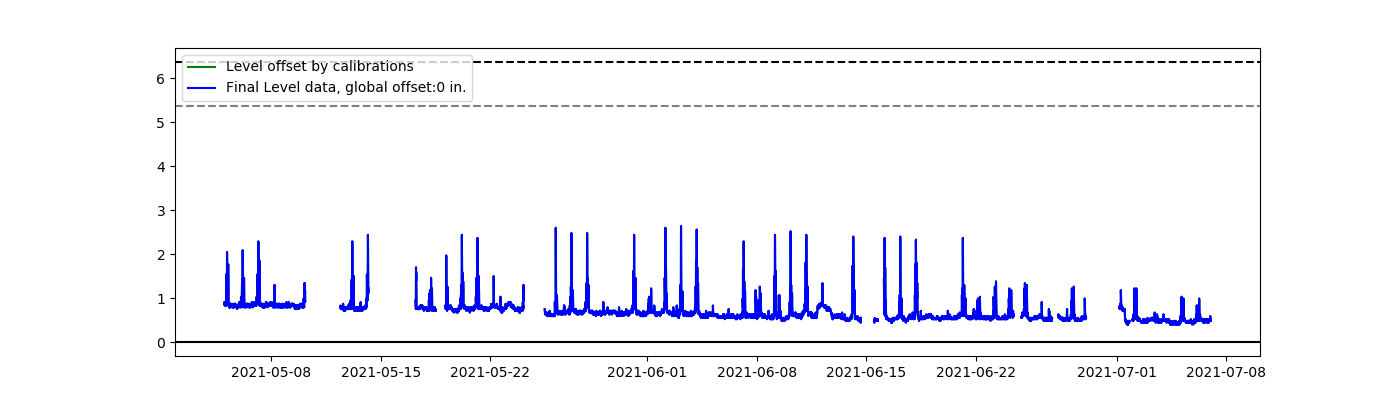

In [826]:
## Get global offset (stored in Google Sheets)
glob_offsets = pd.read_excel(maindir+'PowerBI/Site_List.xlsx',sheet_name='GlobalOffsets',index_col=0)
glob_offset = glob_offsets.loc['MS4-'+site_name,'GlobalOffset_in']
print ('Global offset for '+site_name+' = '+str(glob_offset) +' in.')
## Apply global offset
WL['Level_spec_off_clipbad_calc_off_glob_off'] = WL['Level_spec_off_clipbad_calc_off'] + glob_offset
## Final, offset and cleaned water level data for flow calculation
WL['Level_in'] = WL['Level_spec_off_clipbad_calc_off_glob_off']
## Highlight missing data  
missing_data = pd.DataFrame(WL[np.isnan(WL['Level_in'])]['Level_in'])
missing_data['missing_level_data'] = 0.
missing_data = missing_data.reindex(index=pd.date_range(start_time_loc,end_time_loc,freq='5Min'))

## Display water level data
fig, ax1 = plt.subplots(1,1,figsize=(14,4))
#ax1.plot(WL.index,WL['in Water Level'],marker='None',ls='-',c='grey',label='Raw Level data')
#ax1.plot(WL.index,WL['Level_spec_off'],marker='None',ls='-',c='red',label='Bad data clipped out')
#ax1.plot(WL.index,WL['Level_spec_off_clipbad'],marker='None',ls='-',c='orange',label='Raw Level data + special offset')
ax1.plot(WL.index,WL['Level_spec_off_clipbad_calc_off'],marker='None',ls='-',c='green',label='Level offset by calibrations')
ax1.plot(WL.index,WL['Level_spec_off_clipbad_calc_off_glob_off'],marker='None',ls='-',c='blue',label='Final Level data, global offset:'+str(glob_offset) +' in.')
## Plot field measurements
from matplotlib.dates import DateFormatter, date2num
ax1.axhline(0,c='k')
## Plot maximum v-notch height
ax1.axhline(weir_dims.loc[site_name,'h2_height of vnotch'],color='grey',ls='--')
ax1.axhline(weir_dims.loc[site_name,'h1_height of rectangle'] + weir_dims.loc[site_name,'h2_height of vnotch'],color='k',ls='--')
ax1.legend(loc='upper left')

### Save Total offset
#### >>> Saved in Excel for Power BI

***

In [827]:
FinalOffsets =  pd.read_csv(maindir+'Ancillary_files/FinalOffsets_backup.csv',index_col=0)
FinalOffsets = FinalOffsets[['CalculatedOffset_in','GlobalOffset_in','FinalOffset_in']]
FinalOffsets.loc['MS4-'+site_name,'CalculatedOffset_in'] = np.round(calculated_offset,2)
FinalOffsets.loc['MS4-'+site_name,'GlobalOffset_in'] = np.round(glob_offset,2)
FinalOffset = calculated_offset + glob_offset
FinalOffsets.loc['MS4-'+site_name,'FinalOffset_in'] = np.round(FinalOffset,2)
#save_df_to_GoogleSheets(FinalOffsets, worksheet_name='FinalOffsets',spreadsheet_key="1U0UnBJrpMNEtDYctO2GW0fuobdc8vJfdLIWbvSr--ss")
FinalOffsets.to_csv(maindir+'Ancillary_files/FinalOffsets_backup.csv')

## Display
FinalOffsets.loc['MS4-'+site_name,:]

CalculatedOffset_in   -3.54
GlobalOffset_in        0.00
FinalOffset_in        -3.54
Name: MS4-SWT-030, dtype: float64

## Calculate Flow
### HvF table for 90deg v-notch until water level exceeds v, then CTRSC equation
****

In [828]:
def CTRSC_compound_weir(site_name,WL,weir_dims,plot_timeseries=False,plot_scatter=False):
    ## Get weir dims from sheet
    vnotch_in= float(weir_dims.loc[site_name,['h2_height of vnotch']].values[0])
    b2 = float(weir_dims.loc[site_name,['b2_width of vnotch']].values[0])
    b1 = float(weir_dims.loc[site_name,['b1_left side rectangle']].values[0]) + float(weir_dims.ix[site_name][['b1_right side']].values[0])
    c1 = float(weir_dims.loc[site_name,['c1_top crest left']].values[0])
    c2 = float(weir_dims.loc[site_name,['c2_top crest right']].values[0])
    h1 = float(weir_dims.loc[site_name,['h1_height of rectangle']].values[0])
    
    print (vnotch_in, b2, b1, c1,c2, h1)
        
    #vnotch_cm, width_cm, c1_cm, c2_cm, h1_cm = vnotch_in * 2.54, (b1+b2) * 2.54, c1*2.54, c2*2.54, h1*2.54 
    vnotch_m, width_m, c1_m, c2_m, h1_m = vnotch_in * 0.0254, (b1+b2) * 0.0254, c1*0.0254, c2*0.0254, h1*0.0254
    ## Calculate weir geometry for equation
    b2_cm = b2 * 2.54
    b1_cm = b1 * 2.54
    b1_m, b2_m = b1_cm/100, b2_cm/100
    ## Constants
    Ctd, Crd = 0.579,	0.590
    
    ## Get Level data
    df = WL[['Level_in','Flow_gpm_v']]
    df.columns = ['Level_in','Flow_gpm_v']
    df['Level_in'] = df['Level_in'].where(df['Level_in'] >= 0., np.nan)
    
    ## Format equation inputs
    df['h2(m)'] = df['Level_in'] * 0.0254 ## Height above V
    df['h2_eff(m)'] =  df['h2(m)'] + 0.0008 ## Effective head
    df['h1(m)'] = df['h2(m)'] - vnotch_m ## Height above Horizontal crest
    df['h1_eff(m)'] = df['h1(m)']  + 0.0008 ## Effective head
    
    
    ## Calculate discharge for compound weir - Discussion of “Design and Calibration of a Compound Sharp-Crested Weir” by J. Martínez, J. Reca, M. T. Morillas, and J. G. López,”, 2005
    df['Flow_m3s_ctrsc'] =     ((8./15.) * Ctd * ((2.*9.81)**0.5) * (np.tan(np.radians(90.)/2.)) * (df['h2_eff(m)']**2.5 - df['h1_eff(m)']**2.5))    +     ((2./3.) * Crd * ((2.*9.81)**0.5) * (2 * b1_m) * (df['h1(m)']**1.5))
    ## change from m3/s to gpm
    df['Flow_gpm_ctrsc'] = df['Flow_m3s_ctrsc'] * 15850.372483753
    
    ## Add the flow from the compound weir equation where it is higher than the standard v-notch equation
    df['Flow_gpm'] = df['Flow_gpm_ctrsc'].where((df['Flow_gpm_ctrsc'] > df['Flow_gpm_v']), df['Flow_gpm_v'])

    ## PLOTTING
    if plot_timeseries == True:
        fig, (level,flow) = plt.subplots(2,1,sharex=True,figsize=(12,6))
        ## PLOT LEVEL
        ## Plot total Water Level Height
        level.plot_date(df.index,df['h2(m)'] * 100. /2.54,ls='-',marker='.',label='Level inches',c='b')
        ## Plot overtopping Water Level 
        level.plot_date(df.index,(df['h1(m)'] + vnotch_m)* 100. /2.54,ls='-',marker='.',label='Height above horizontal crest (in)',c='r')
        ## Add line at vnotch height
        level.axhline(vnotch_in,c='r')
        level.set_ylabel('Level_in)',fontweight='bold')
        
        ## PLOT FLOW
        flow.plot_date(df.index,df['Flow_gpm'],ls='-',marker='.',label='Flow: HvF and ctrsc',c='r')
        flow.plot_date(df.index,df['Flow_gpm_v'],ls='-',marker='.',label='Flow just V',c='b')
#        flow.plot_date(df.index,df['Flow (gpm) compound'],ls='-',marker='.',label='Flow compound',c='g')
        flow.set_ylabel('Flow (gpm)',fontweight='bold')
        
        ## fmt
        level.legend(), flow.legend()
        plt.tight_layout()
        
        
    if plot_scatter == True:
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        ax.plot(df['Level_in'], df['Flow_gpm_ctrsc'],ls='None',marker='.',c='r',label='Compound weir equation')
        ax.plot(df['Level_in'], df['Flow_gpm_v'],ls='None',marker='.',c='b',label='V-notch equation')
        ax.set_xlabel('Level (inches)',fontweight='bold'), ax.set_ylabel('Flow (gpm)',fontweight='bold')
        ax.legend(loc='upper left')
        plt.tight_layout()

    return df['Flow_gpm'].astype('float').round(3)

In [829]:
if site_name == 'CAR-059':
    print ('Using trap equation')
    def trapezoidal_flume(x):
        x_ft = x/12. ## inches to ft
        if x_ft>0.:
            gpm = 1490. * (x_ft ** 2.32)
        elif x_ft<=0:
            gpm=0.
        elif np.isnan(x_ft):
            gpm=np.nan
        return gpm
    WL['Flow_gpm'] = WL['Level_in'].apply(lambda x: trapezoidal_flume(x))    
    
else:
    ## HvF table for 90 deg v-notch
    def level_to_gpm_vnotch(x):
        if x < 0:
            gpm = 0.0
        else:
            gpm = HvF.loc[np.round(x,2)]['Q (GPM)']
        return gpm
    WL['Flow_gpm_v'] = WL['Level_in'].apply(lambda x: level_to_gpm_vnotch(x))    
    ## Calculate flows when overtopping the weir
    WL['Flow_gpm'] = CTRSC_compound_weir(site_name, WL, weir_dims)#,  True, True)
    #WL[['Level_in','Flow_gpm']].plot(figsize=(14,4),grid=True)

C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


5.375 10.75 11.5 7.5 7.5 1.0


C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [830]:
WL.dropna().head()

,in Water Level,spec_offset,Level_spec_off,Level_spec_off_clipbad,Level_spec_off_clipbad_calc_off,Level_spec_off_clipbad_calc_off_glob_off,Level_in,Flow_gpm_v,Flow_gpm
2021-05-05 00:00:00,4.41,0.0,4.41,4.41,0.87,0.87,0.87,1.588,1.588
2021-05-05 00:05:00,4.45,0.0,4.45,4.45,0.91,0.91,0.91,1.777,1.777
2021-05-05 00:10:00,4.41,0.0,4.41,4.41,0.87,0.87,0.87,1.588,1.588
2021-05-05 00:15:00,4.41,0.0,4.41,4.41,0.87,0.87,0.87,1.588,1.588
2021-05-05 00:20:00,4.41,0.0,4.41,4.41,0.87,0.87,0.87,1.588,1.588


## QC Hydrograph and Clip storm flow
***

In [831]:
weir_dims.head()


,Measured datetime,b1_left side rectangle,b1_right side,b2_width of vnotch,h1_height of rectangle,h2_height of vnotch,c1_top crest left,c2_top crest right
Site,,,,,,,,
CAR-059,5/18/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAR-070,5/21/2021,4.0,4.0,12.0,2.0,6.0,13.00,15.50
CAR-070E,5/19/2021,5.5,5.0,15.0,2.0,7.5,7.50,2.50
CAR-072,5/21/2021,4.0,4.0,12.0,2.0,6.0,16.50,17.00
CAR-072C,5/21/2021,4.0,4.0,12.0,2.0,6.0,4.75,4.75


Clipping stormflow data....
Clipped storm data from: 05/18/21 00:00-05/19/21 00:00


<IPython.core.display.Javascript object>


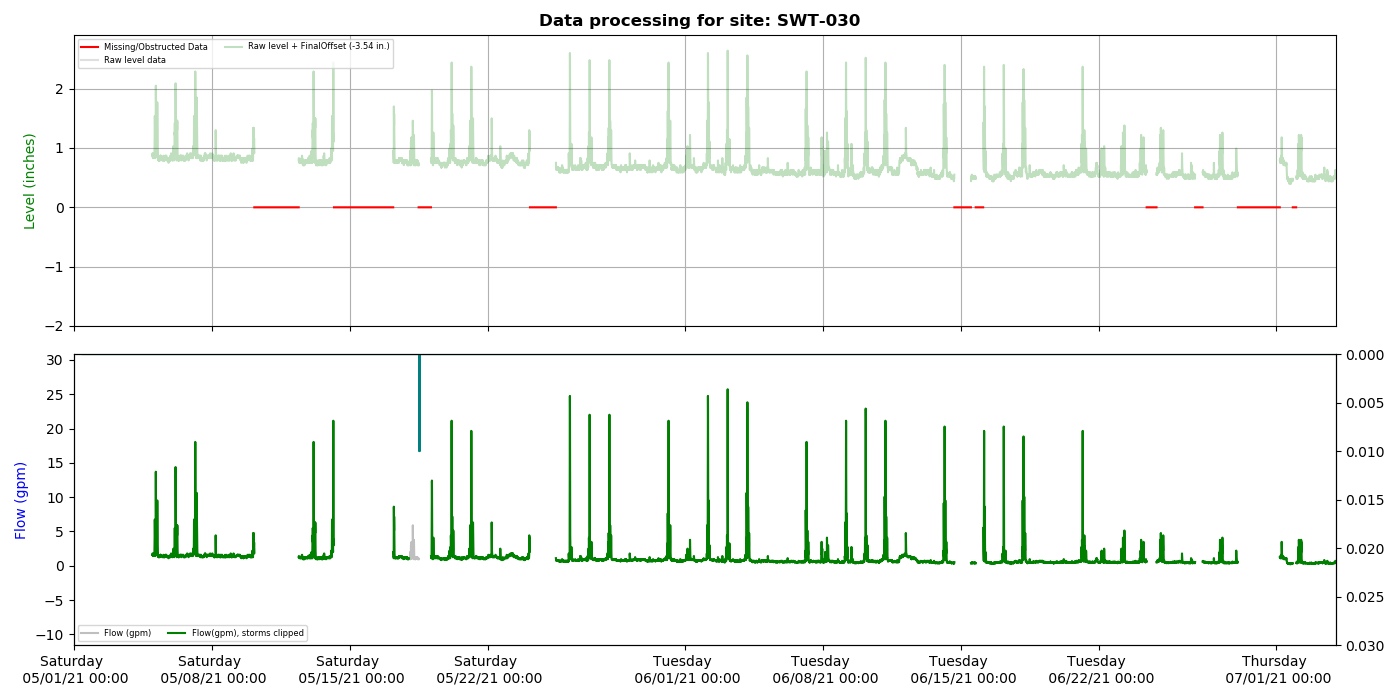

C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


In [832]:
## Clip storm flows
clips =  pd.read_excel(maindir+'PowerBI/Site_List.xlsx',sheet_name='ClipBadData',index_col=0)
try: # one entry dataframes are weird
    clips_for_site = pd.DataFrame(clips.loc['MS4-'+site_name,:])
    storm_clips = clips_for_site[clips_for_site['Reason']=='Storm']
except:
    try:
        clips_for_site = pd.DataFrame(clips.loc['MS4-'+site_name,:]).T # have to make DF and Transpose it 
        storm_clips = clips_for_site[clips_for_site['Reason']=='Storm'] 
    except KeyError:
        storm_clips = pd.DataFrame()
## iterate over list of bad data and clip from 'Flow_gpm'....
print ('Clipping stormflow data....')
WL['Flow_gpm_storm_clipped'] = WL['Flow_gpm']
for clip in storm_clips.iterrows():
    clip_start, clip_end = clip[1]['Start'], clip[1]['End']
    if pd.isnull(clip_start)==False and pd.isnull(clip_end) == False:
        print ('Clipped storm data from: '+clip_start.strftime('%m/%d/%y %H:%M')+'-'+clip_end.strftime('%m/%d/%y %H:%M'))
        ## set data in WL indices to nan
        WL.loc[clip_start:clip_end, ['Flow_gpm_storm_clipped']] = np.nan
    else:
        print ('No data to clip...')
        pass   
storm_clips
########################################
##### QC Hydrograph ###################
#####################################
fig, (ax1, ax4) = plt.subplots(2,1,figsize=(14,7),sharex=True)
## Plot full scale level data
ax1.plot_date(missing_data.index,missing_data['missing_level_data'],marker='None',ls='-',c='r',label='Missing/Obstructed Data')
## raw
ax1.plot_date(WL.index, WL['in Water Level'], marker='None',ls='-',c='grey',alpha=0.25,label='Raw level data')
##raw +final offset
ax1.plot_date(WL.index, WL['Level_in'], marker='None',ls='-',c='g',alpha=0.25,label='Raw level + FinalOffset ('+"%.2f"%FinalOffset+' in.)')
## Plot maximum v-notch height
ax1.axhline(weir_dims.loc[site_name,'h2_height of vnotch'],color='grey')
ax1.axhline(weir_dims.loc[site_name,'h1_height of rectangle'] + weir_dims.loc[site_name,'h2_height of vnotch'],color='k')
textstr = 'Weir crest height: '+str(weir_dims.loc[site_name,'h2_height of vnotch'])+' inches'
#ax1.annotate(textstr, (mpl.dates.date2num(pd.to_datetime(weir_dims.loc['CAR-007','Measurement date'])),weir_dims.loc[site_name,'h2']))
## Plot flow data, compound weir
ax4.plot_date(WL.index, WL['Flow_gpm'], marker='None',ls='-',c='grey',alpha=0.5,label='Flow (gpm)')
## Plot flow data, storms clipped
ax4.plot_date(WL.index, WL['Flow_gpm_storm_clipped'], marker='None',ls='-',c='green',label='Flow(gpm), storms clipped')
## Previous deliverable data
#ax4.plot_date(del_df.index,del_df['Flow compound weir (gpm)'], marker='None',ls='-',c='b',label='Previous deliverable')
### Plot precip on inverted, secondary y axis
ax4_2 = ax4.twinx()
ax4_2.plot_date(Rain1H.index, Rain1H['Rain_in'], marker='None',ls='steps-mid',color='teal',label='Precip: '+rain_gauge_name)
## Format/set limits
## full scale flow
ax1.set_ylim(-2, WL['Level_in'].max() * 1.1)
#ax2.set_ylim(-WL['offset_flow'].max() * 0.5, WL['offset_flow'].max() * 2.)
ax4_2.set_ylim(0, Rain1H['Rain_in'].max() * 3.)
ax4_2.invert_yaxis()
## low flow
ax4.set_ylim(-WL['Flow_gpm_storm_clipped'].max() * 0.45, WL['Flow_gpm_storm_clipped'].max() * 1.2)
## set x-axis to monitoring period
ax1.set_xlim(start_time_loc, end_time_loc)
ax1.grid(True)
ax1.set_ylabel('Level (inches)',color='g')

ax4.set_ylabel('Flow (gpm)',color='b')
ax1.legend(fontsize=6,numpoints=1,ncol=2,loc='upper left')
ax4.legend(fontsize=6,numpoints=1,ncol=5,loc='lower left')
ax4.xaxis.set_major_formatter(mpl.dates.DateFormatter('%A \n %m/%d/%y %H:%M'))
fig.suptitle('Data processing for site: '+site_name,fontsize=12,fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

## Hydrograph Separation
***

C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

<IPython.core.display.Javascript object>


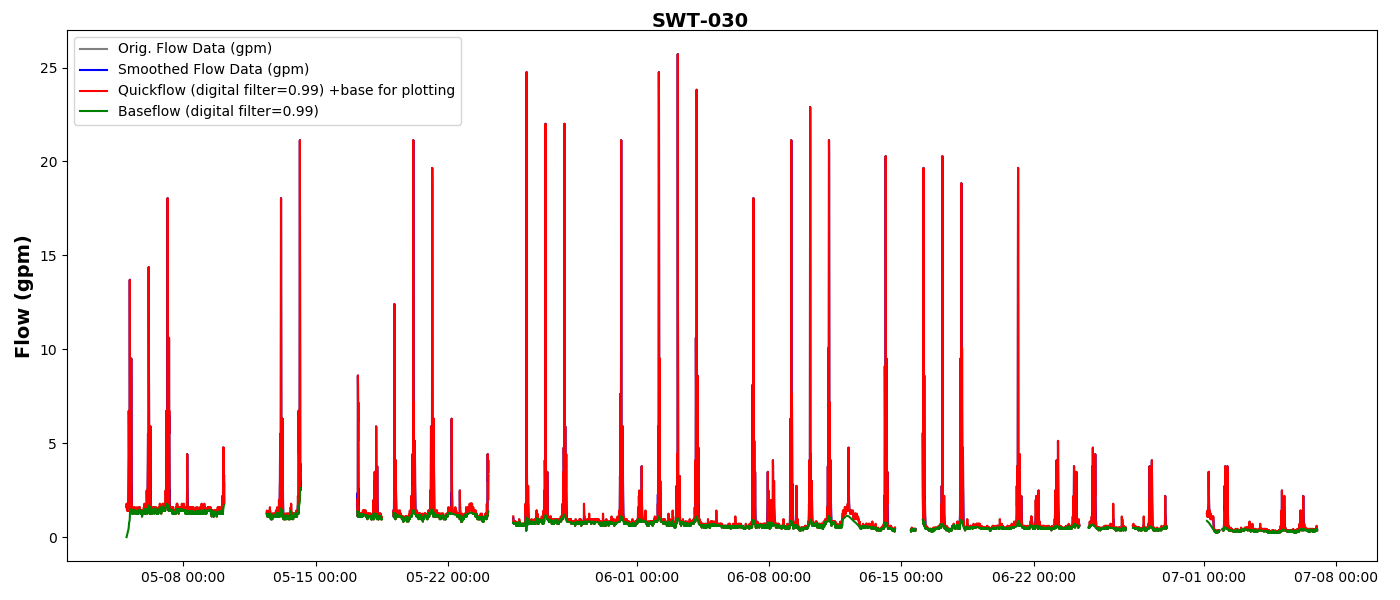

In [833]:
alpha = 0.990
flow_df = WL[[u'Flow_gpm']]
## gap fill
flow_df = flow_df.fillna(flow_df.interpolate(method='linear')).fillna(flow_df.mode().loc[0].values[0])
#flow_df[''Flow_compound_weir'].plot(c='b')
## Function to add original flow peaks back into dataset
def peaks(original_flow, smoothed, peak_val=2):
    if abs(original_flow - smoothed) > peak_val:
        flow = original_flow
    else:
        flow = smoothed
    return flow
## Smoothing
flow_df['rolling'] = flow_df['Flow_gpm'].rolling(12,min_periods=3,center=True).mean()
#flow_df['rolling'].plot(c='g') 
## Add peaks back into rolling data
flow_df['rolling+peaks']  = flow_df.apply(lambda x: peaks(x['Flow_gpm'],x['rolling']), axis=1)
#flow_df['rolling+peaks'].plot(c='r')
## Butter filter
b, a = signal.butter(3, 0.2, btype='lowpass', analog=False) ## 0.2 parameter selected by trial and error
flow_df['butter'] = signal.filtfilt(b, a, flow_df['rolling+peaks'])
#flow_df['butter'].plot(c='orange')
flow_df['butter+peaks']  = flow_df.apply(lambda x: peaks(x['Flow_gpm'],x['butter'], 1.), axis=1)
## CHoose a smoothed dataset to apply the DF to
flow_df['Flow (gpm) smooth'] = flow_df['butter+peaks']
## Set arbitrary index
flow_df = flow_df.reset_index()
## Baseflow df    
df = flow_df
## Define h_k1 (original flow data series
df['h_k1'] = df['Flow (gpm) smooth']
### BACKWARD FILTER
## Fill in first value for q_k-1
df.loc[0,'q_k-1'] = df.loc[0,'h_k1']
## q_k-1
for i in range(1,len(df)):
    # (0.925 * q_k-1) + (((1+0.925)/2) * (q_k - q_k-1))
    df.loc[i,'q_k-1'] = (alpha*df.loc[i-1,'q_k-1']) + (((1.+alpha)/2.) * (df.loc[i,'h_k1'] - df.loc[i-1,'h_k1']))
## Change negatives to 0's
df['q_k-1>0'] = df['q_k-1'].where(df['q_k-1']>0., 0.)
## b_k1
df['b_k1'] = df['h_k1'] - df['q_k-1>0']
## FORWARD FILTER
df['h_k2'] = df['h_k1'] - df['b_k1']
## Fill in first value for q_k+1
df.loc[df.index[-1],'q_k+1'] = 0.
##q_k+1
for i in range(df.index[-2],0,-1): ## iterate backwards
    # (0.925 * q_k+1) + (((1+0.925)/2) * (q_k - q_k-1))
    df.loc[i,'q_k+1'] = (alpha*df.loc[i+1,'q_k+1']) + (((1.+alpha)/2.) * (df.loc[i,'b_k1'] - df.loc[i+1,'b_k1']))
## change negatives to 0's
df['q_k+1>0'] = df['q_k+1'].where(df['q_k+1']>=0, 0.)
## b_k2
df['b_k2'] = df['b_k1'] - df['q_k+1>0']
## Rest values back to date
df = df.set_index(df['index'])
## Deliver
df[['h_k1','b_k1','b_k2']]
flowoutput = df[['Flow_gpm','Flow (gpm) smooth']]
flowoutput['Baseflow (gpm)'] = df['b_k2']
flowoutput['Baseflow (gpm)'] = np.where(flowoutput['Baseflow (gpm)']<=flowoutput['Flow_gpm'], flowoutput['Baseflow (gpm)'], flowoutput['Flow_gpm'])
flowoutput.loc[:,'Quickflow (gpm)'] = flowoutput['Flow_gpm'] - flowoutput['Baseflow (gpm)']
## Put in original flow data and Mask where Nan values in orginal dataset
flowoutput.loc[:,'Flow_gpm'] = WL[[u'Flow_gpm']]
m = pd.notnull(flowoutput['Flow_gpm'])
flowoutput = flowoutput.where(m, np.nan)   
WL.loc[:,'Baseflow (gpm)'] = flowoutput['Baseflow (gpm)'].round(3)
WL.loc[:,'Quickflow (gpm)'] = flowoutput['Quickflow (gpm)'].round(3)
## Drop data for data dropouts
WL['Baseflow (gpm)'] = np.where(WL['Level_in'].isnull(),np.nan,WL['Baseflow (gpm)'])
WL['Baseflow (gpm)'] = np.where(WL['Level_in']<0.,0.,WL['Baseflow (gpm)']) 
WL['Baseflow (gpm)'] = np.where(WL['Baseflow (gpm)']<0.,0.,WL['Baseflow (gpm)'])## Get rid of negative values
WL['Quickflow (gpm)'] = np.where(WL['Level_in'].isnull(),np.nan,WL['Quickflow (gpm)'])
#%% BASEFLOW PLOT
## PLOT
#    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,10),sharex=True)
fig, ax1 = plt.subplots(1,1,figsize=(14,6))
fig.suptitle(site_name,fontsize=14, fontweight='bold')
## Flow
ax1.plot_date(WL.index, WL['Flow_gpm'],marker='None',ls='-',label='Orig. Flow Data (gpm)',c='grey')
ax1.plot_date(flowoutput.index, flowoutput['Flow (gpm) smooth'],marker='None',ls='-',label='Smoothed Flow Data (gpm)',c='b')
ax1.plot_date(WL.index, WL['Baseflow (gpm)'] + WL['Quickflow (gpm)'],marker='None',ls='-',label='Quickflow (digital filter='+str(alpha)+') +base for plotting',c='r')
ax1.plot_date(WL.index, WL['Baseflow (gpm)'],marker='None',ls='-',label='Baseflow (digital filter='+str(alpha)+')',c='g')
ax1.set_ylabel('Flow (gpm)',fontweight='bold',fontsize=14)
for ax in fig.axes:
    ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m-%d %H:%M'))
plt.tight_layout()
plt.subplots_adjust(top=0.95,hspace=0.05)

## SAVE TO EXCEL
***

C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


SWT-030-all flow
SWT-030-stormflow clipped
Max Row: 16417
Rain Max Row: 67
27 Monday B
28 Tuesday C
29 Wednesday D
30 Thursday E
31 Friday F
32 Saturday G
33 Sunday H


C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


<IPython.core.display.Javascript object>


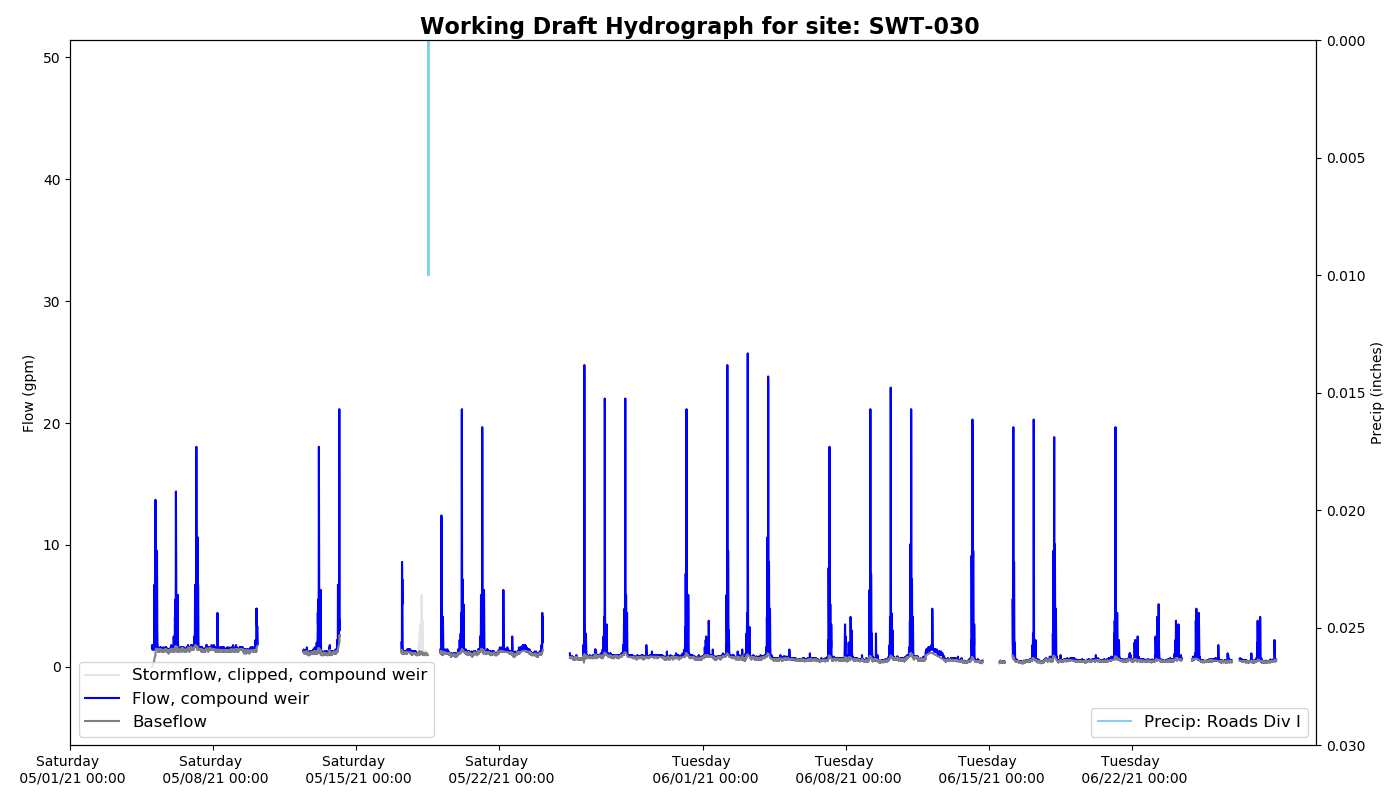

C:\Spyder-python3\WPy64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:110: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


In [834]:
def xl_columnrow(col,row=''):
    """ Convert given row and column number to an Excel-style cell name. """
    LETTERS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    result = []
    while col:
        col, rem = divmod(col-1, 26)
        result[:0] = LETTERS[rem]
    return ''.join(result)+str(row)
## Get rid of all data for data dropouts
for col in WL.columns:
    #print col
    try:
        WL[col] = np.where(WL['Level_in'].isnull(),np.nan,WL[col])
    except:
        print ('skipped col: '+col)
        pass
### FINALIZED FLOW OUTPUT
WLout = WL.ix[start_time_loc:data_deliverable_end_time_loc]
## For cams
WLout[['Flow_gpm','Level_in']].to_csv(maindir+'Level_and_Flow_output/'+site_name+'_level_and_flow.csv')
## FLOW
Corr_flow = WLout[['Flow_gpm', 'Flow_gpm_storm_clipped']].round(3)
Corr_flow.columns = ['Flow compound weir (gpm)', 'Flow compound weir stormflow clipped (gpm)']
## Add base/quickflow
Corr_flow[['Baseflow (gpm)','Quickflow (gpm)']] = WLout[['Baseflow (gpm)','Quickflow (gpm)']]
## Add temp and conductivity to deliverable
#Corr_flow[u'uS/cm EC'] = np.round(WLout[u'mS/cm EC'] * 1000., 0)
#temp_col_name = [col for col in WLout.columns if 'Water Temperature' in col]
#Corr_flow[u'\xb0F Water Temperature'] = WLout[temp_col_name].round(1)
## PIVOT TABLE STUFF
Corr_flow.loc[:,('Year')] = Corr_flow.index.year
Corr_flow.loc[:,('Month')] = Corr_flow.index.month
Corr_flow.loc[:,('Day')] = Corr_flow.index.day
Corr_flow.loc[:,('Hour')] = Corr_flow.index.hour
Corr_flow.loc[:,('Minute')] = Corr_flow.index.minute
Corr_flow.loc[:,('Weekday')] = Corr_flow.index.map(lambda x: calendar.day_name[x.weekday()])
## Kick out to Excel
final_flow_ExcelFile = pd.ExcelWriter(maindir+'Flow_Output_Excel_files/'+site_name+'-working draft.xlsx')
max_row, rain_max_row = Excel_Plots(site_name, Corr_flow, Rain1D, final_flow_ExcelFile, start_time_loc, data_deliverable_end_time_loc)
### Pivot TABLES
## Old style-SUM but ADDING the multiplication by 5min (gpm->gp5M)
#PivotTable_Sum = pd.pivot_table(Corr_flow,values='Flow compound weir stormflow clipped (gpm)', columns=['Month','Day','Weekday'], index=['Hour'], aggfunc=np.sum).round(1) * 5. # *5 for 5Min interval data
#PivotTable_Sum.to_excel(final_flow_ExcelFile,site_name+'PivotTable-Sum')
## Freeze Panes
#final_flow_ExcelFile.sheets[site_name+'PivotTable-Sum'].freeze_panes(4, 1)
## Conditional Formatting
def rgb_hex(red,green,blue):
    return '#%02x%02x%02x' % (red, green, blue)
green, yellow, red = rgb_hex(99,190,123),rgb_hex(255,235,132),rgb_hex(248,105,107)
#max_col_row = xl_columnrow(len(PivotTable_Sum.columns)+1,28) #24th hour is on row 28
#final_flow_ExcelFile.sheets[site_name+'PivotTable-Sum'].conditional_format('B5:'+max_col_row, {'type': '3_color_scale','min_color': green,'mid_color':yellow,'max_color':red})
## Old style-AVG
PivotTable_Avg = pd.pivot_table(Corr_flow,values='Flow compound weir stormflow clipped (gpm)', columns=['Month','Day','Weekday'], index=['Hour'], aggfunc=np.mean).round(3)
PivotTable_Avg.to_excel(final_flow_ExcelFile,site_name+'PivotTable-Avg')
## Freeze Panes
final_flow_ExcelFile.sheets[site_name+'PivotTable-Avg'].freeze_panes(4, 1)
## Conditional Formatting
max_col_row = xl_columnrow(len(PivotTable_Avg.columns)+1,28)  #24th hour is on row 28
final_flow_ExcelFile.sheets[site_name+'PivotTable-Avg'].conditional_format('B5:'+max_col_row, {'type': '3_color_scale','min_color': green,'mid_color': yellow,'max_color': red})
## Seven day Average style
PivotTable = pd.pivot_table(Corr_flow,values='Flow compound weir stormflow clipped (gpm)',columns=['Weekday'],index=['Hour'],aggfunc=np.mean)
col_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
PivotTable = PivotTable.reindex_axis(col_order,axis=1)
PivotTable.to_excel(final_flow_ExcelFile,site_name+'PivotTable-Avg7day')
## Format Pivot Table 
pivot = final_flow_ExcelFile.sheets[site_name+'PivotTable-Avg7day']
## Conditional formatting
# Add a format. Yellow fill with RED text.
redtxt = final_flow_ExcelFile.book.add_format({'bg_color': '#FFFF00',
                           'font_color': '#FF0000'})
# Add a format. Yellow fill with black text.
blacktxt = final_flow_ExcelFile.book.add_format({'bg_color': '#FFFF00',
                           'font_color': '#000000'})
day_cols={'Monday':'B','Tuesday':'C','Wednesday':'D','Thursday':'E','Friday':'F','Saturday':'G','Sunday':'H'}
col_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for index, letter in enumerate(string.ascii_uppercase[1:9]):
    ## Count cells over 25th percentile
    pivot.write_formula(25,index, '=SUMPRODUCT(--('+letter+'2:'+letter+'25>PERCENTILE($B$2:$H$25,0.85)))')
## Annotate
pivot.write(25,0, 'Count>15% by day')
pivot.write(26,3, 'Count>15% by day')
for i, day in zip(np.arange(27,34,1),col_order):
    col = day_cols[day]
    print (i, day, col)
    pivot.write(i,0,day)
    pivot.write_formula(i,1,'=AVERAGE('+col+'2:'+col+'25)')
    pivot.write(i,2,'>Avg')
    pivot.write_formula(i,3,'=SUM('+col+'26)')
    ## Conditionally format each day
    pivot.conditional_format(col+'2:'+col+'25', {'type': 'cell','criteria': '>=','value':'$B$35','format': redtxt})
    pivot.conditional_format(col+'2:'+col+'25', {'type': 'cell','criteria': '>=','value':'$B$'+str(i+1),'format': blacktxt})
pivot.write(34,0,'Top 15th%ile (excluding zeros)')
pivot.write_formula(34,1,'=PERCENTILE(IF(B2:H25>0, B2:H25), 0.85)')
pivot.write(34,2,'>15th%ile excl 0s')
pivot.write(34,3,'(need to hit F2, then Ctrl+Shift+Enter to execute equation if you edit it)')
pivot.write(35,0,'Top 15th%ile (including zeros)')
pivot.write_formula(35,1,'=PERCENTILE(B2:H25,0.85)')
pivot.write(35,2,'>15th%ile incl 0s')
### SAVE FINAL FILE
final_flow_ExcelFile.save()
# Final Hydrograph    
fig, ax1 = plt.subplots(1,1,figsize = (14,8))
## FLOW
ax1.plot_date(Corr_flow.index, Corr_flow['Flow compound weir (gpm)'], marker='None', ls='-', c='grey',alpha=0.2,label='Stormflow, clipped, compound weir')
ax1.plot_date(Corr_flow.index, Corr_flow['Flow compound weir stormflow clipped (gpm)'], marker='None', ls='-', c='b',label='Flow, compound weir')
## BASEFLOW
ax1.plot_date(Corr_flow.index,Corr_flow['Baseflow (gpm)'], marker='None', ls='-', c='grey',label='Baseflow')
## RAIN
ax2 = ax1.twinx()
ax2.plot_date(Rain1H.index, Rain1H['Rain_in'], marker='None',ls='steps-mid',color='skyblue',label='Precip: '+site_list.loc['MS4-'+site_name,'rain_gauge_name'])
## FORMAT
ax1.set_ylim(-Corr_flow['Flow compound weir stormflow clipped (gpm)'].max() * 0.25, Corr_flow['Flow compound weir stormflow clipped (gpm)'].max() * 2.)
ax2.set_ylim(0, Rain1H['Rain_in'].max() * 3.)
ax2.invert_yaxis()
## LEGEND
ax1.legend(fontsize=12,loc='lower left'), ax2.legend(fontsize=12,loc='lower right')
ax1.set_ylabel('Flow (gpm)'), ax2.set_ylabel('Precip (inches)')
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%A \n %m/%d/%y %H:%M'))
plt.xticks(rotation=90)
## set x-axis to monitoring period
ax1.set_xlim(start_time_loc, data_deliverable_end_time_loc)
fig.suptitle('Working Draft Hydrograph for site: '+site_name,fontsize=16,fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
fig.savefig(maindir+'Flow_Output_Excel_files/Hydrographs/'+site_name+'-working hydrograph.png')